# Backtest Trading Strategies

In [16]:
import yfinance as yf
import datetime
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
from IPython.display import display, HTML

[*********************100%%**********************]  1 of 1 completed


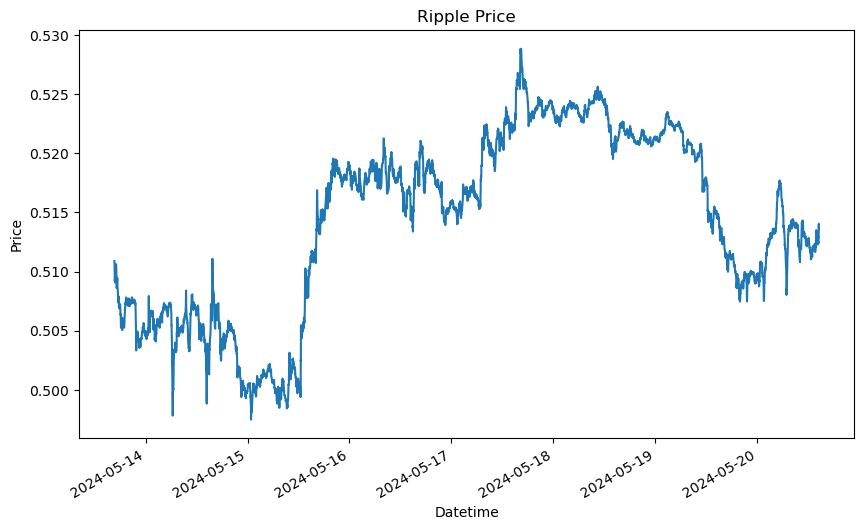

In [17]:
start = dt.datetime.now() - dt.timedelta(7)
end = dt.datetime.now()
df = yf.download('XRP-USD', start=start, end=end, interval='1m')['Adj Close']

plt.figure(figsize=(10, 6))
plt.title('Ripple Price')
df.plot()
plt.ylabel('Price')
plt.show()

In [18]:
def backtest(df, COMMS=0.005):
    # Initialize variables
    trend_ema = df.ewm(200, adjust=False).mean()
    macd = calculate_macd(df)
    inpos = 0
    entry = None
    results = []
    unrealized_pnl = []
    
    for i in range(1, len(df)):
        # Calculate unrealized PnL
        unr = ((df.iloc[i] - df.iloc[i-1]) / df.iloc[i-1]) * inpos

        # Open Long
        if inpos == 0 and df.iloc[i] > trend_ema.iloc[i] and macd['MACD_Line'].iloc[i] > macd['Signal_Line'].iloc[i] and macd['MACD_Line'].iloc[i - 1] < macd['Signal_Line'].iloc[i - 1] and macd['MACD_Line'].iloc[i] < 0:
            entry = df.iloc[i]
            inpos = 1
            start = df.index[i]
            unr -= COMMS / 2

        # Open Short
        elif inpos == 0 and df.iloc[i] < trend_ema.iloc[i] and macd['MACD_Line'].iloc[i] < macd['Signal_Line'].iloc[i] and macd['MACD_Line'].iloc[i - 1] > macd['Signal_Line'].iloc[i - 1] and macd['MACD_Line'].iloc[i] > 0:
            entry = df.iloc[i]
            inpos = -1
            start = df.index[i]
            unr -= COMMS / 2

        # Close Long
        elif inpos == 1 and (df.iloc[i] < trend_ema.iloc[i] or macd['MACD_Line'].iloc[i] < macd['Signal_Line'].iloc[i]):
            pnl = (df.iloc[i] - entry) / entry - COMMS
            hold_time = (df.index[i] - start).total_seconds()
            results.append([start, df.index[i], pnl, hold_time])
            unr -= COMMS / 2
            inpos = 0

        # Close Short
        elif inpos == -1 and (df.iloc[i] > trend_ema.iloc[i] or macd['MACD_Line'].iloc[i] > macd['Signal_Line'].iloc[i]):
            pnl = (entry - df.iloc[i]) / entry - COMMS
            hold_time = (df.index[i] - start).total_seconds()
            results.append([start, df.index[i], pnl, hold_time])
            unr -= COMMS / 2
            inpos = 0
            
        unrealized_pnl.append((df.index[i], unr))
    
    # Convert results to DataFrame
    pnl_df = pd.DataFrame(results, columns=['Entry_Date', 'Exit_Date', 'PnL', 'Hold_Time'])
    unrealized_df = pd.DataFrame(unrealized_pnl, columns=['Date', 'Unrealized_PnL'])

    return pnl_df, unrealized_df


def calculate_metrics(pnl, unr, df):
    benchmark = df.pct_change()
    sharpe = unr['Unrealized_PnL'].mean() / unr['Unrealized_PnL'].std() * np.sqrt(252 * 390) # Annualize Sharpe Ratio
    ppt = pnl['PnL'].mean() # Profit per Trade
    avg_holding_time = pnl['Hold_Time'].mean() / 60 # Average Holding Time in Minutes
    beta = np.corrcoef(benchmark.iloc[2:], unr['Unrealized_PnL'].iloc[1:])[0,1] # Beta with underlying

    metrics_df = pd.DataFrame({
    'Metric': ['Sharpe Ratio', 'Profit Per Trade', 'Average Holding Time (days)', 'Beta'],
    'Value': [sharpe, ppt, avg_holding_time, beta]
    })

    cumret = (1 + unr['Unrealized_PnL']).cumprod() - 1 # Cumulative Return
    drawdown = (1 + cumret) / (1 + cumret.expanding().max()) - 1 # Drawdown

    display(HTML(metrics_df.to_html(index=False, justify='center'))) # Display Numerical Metrics

    # Show Performance
    plt.figure(figsize=(10, 6))
    plt.plot(unr['Date'], (1 + unr['Unrealized_PnL']).cumprod() - 1, label='Strategy')
    plt.plot((1 + benchmark).cumprod() - 1, label='Benchmark')
    plt.plot(pnl['Exit_Date'], (1 + pnl['PnL']).cumprod() - 1, '-o')
    plt.title('Cumulative Return')
    plt.legend()
    plt.show()

    # Show Underwater Plot
    plt.figure(figsize=(10, 6))
    plt.plot(unr['Date'], drawdown)
    plt.title('Drawdown')
    plt.show()

In [19]:
def calculate_rsi(df, window=14):
    # Calculate price differences
    delta = df.diff()

    # Separate positive and negative gains
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    # Calculate the average gain and loss
    avg_gain = gain.rolling(window=window, min_periods=1).mean()
    avg_loss = loss.rolling(window=window, min_periods=1).mean()

    # Calculate the RS (Relative Strength)
    rs = avg_gain / avg_loss

    # Calculate the RSI
    rsi = 100 - (100 / (1 + rs))

    return rsi


def calculate_macd(df, short_window=12, long_window=26, signal_window=9):
    """
    Calculate the MACD indicator for a given price series.
    
    :param df: pd.DataFrame or pd.Series - A series of prices.
    :param short_window: int - The short window period for the fast EMA (default is 12).
    :param long_window: int - The long window period for the slow EMA (default is 26).
    :param signal_window: int - The signal line period (default is 9).
    :return: pd.DataFrame - A DataFrame with columns for the MACD line, signal line, and MACD histogram.
    """
    # Calculate the short and long EMAs
    short_ema = df.ewm(span=short_window, adjust=False).mean()
    long_ema = df.ewm(span=long_window, adjust=False).mean()

    # Calculate the MACD line
    macd_line = short_ema - long_ema

    # Calculate the signal line
    signal_line = macd_line.ewm(span=signal_window, adjust=False).mean()

    # Calculate the MACD histogram
    macd_histogram = macd_line - signal_line

    # Create a DataFrame to hold all MACD related values
    macd = pd.DataFrame({
        'MACD_Line': macd_line,
        'Signal_Line': signal_line,
        'MACD_Histogram': macd_histogram
    })

    return macd


def plot_macd(macd_df, title='MACD'):
    """
    Plot the MACD indicator with the specified requirements.
    
    :param macd_df: pd.DataFrame - A DataFrame with columns for the MACD line, signal line, and MACD histogram.
    :param title: str - The title of the plot (default is 'MACD').
    """
    plt.figure(figsize=(12, 8))

    # Plot MACD and signal lines
    plt.plot(macd_df.index, macd_df['MACD_Line'], label='MACD Line', color='blue', linewidth=2)
    plt.plot(macd_df.index, macd_df['Signal_Line'], label='Signal Line', color='red', linestyle='--', linewidth=2)

    # Plot MACD histogram with color
    plt.bar(macd_df.index, macd_df['MACD_Histogram'], color=np.where(macd_df['MACD_Histogram'] >= 0, 'green', 'red'))

    # Add zero line
    plt.axhline(0, color='yellow', linestyle='--', linewidth=1)

    # Add labels and title
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('MACD')
    plt.legend(loc='upper left')

    # Show the plot
    plt.show()

## Backtest without Transaction Costs

Metric,Value
Sharpe Ratio,12.293124
Profit Per Trade,0.000499
Average Holding Time (days),18.233333
Beta,-0.051752


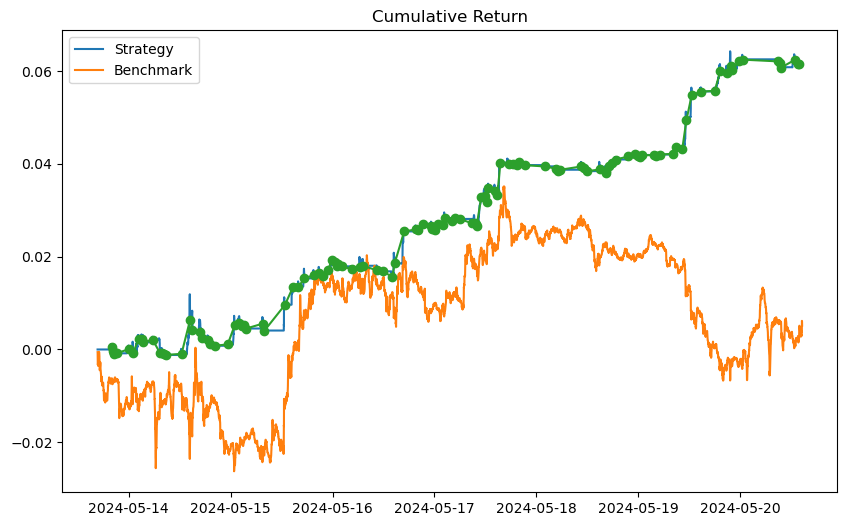

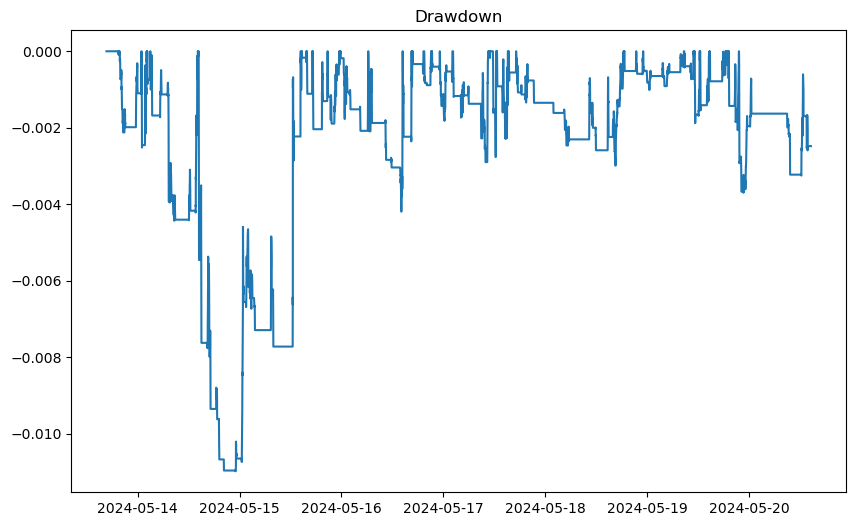

In [22]:
pnl, unr = backtest(df, 0)
calculate_metrics(pnl, unr, df)

## Backtest with Transaction Costs

Metric,Value
Sharpe Ratio,-10.684429
Profit Per Trade,-0.000501
Average Holding Time (days),18.233333
Beta,-0.050725


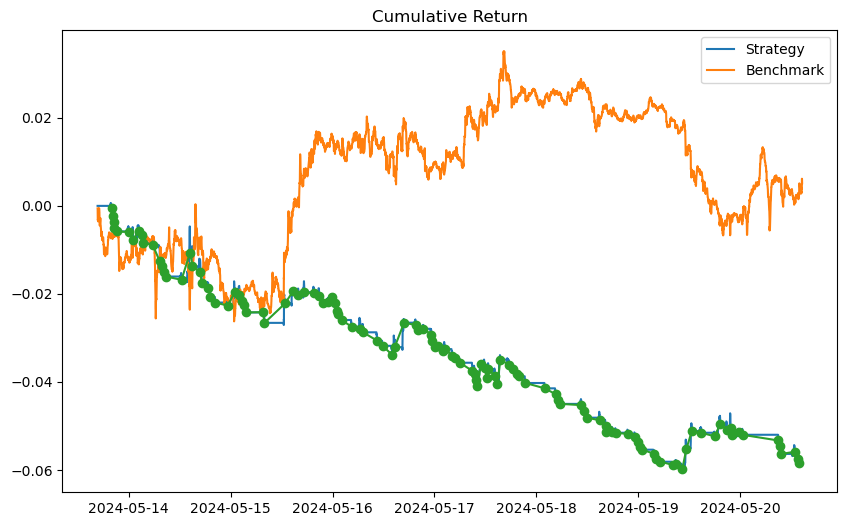

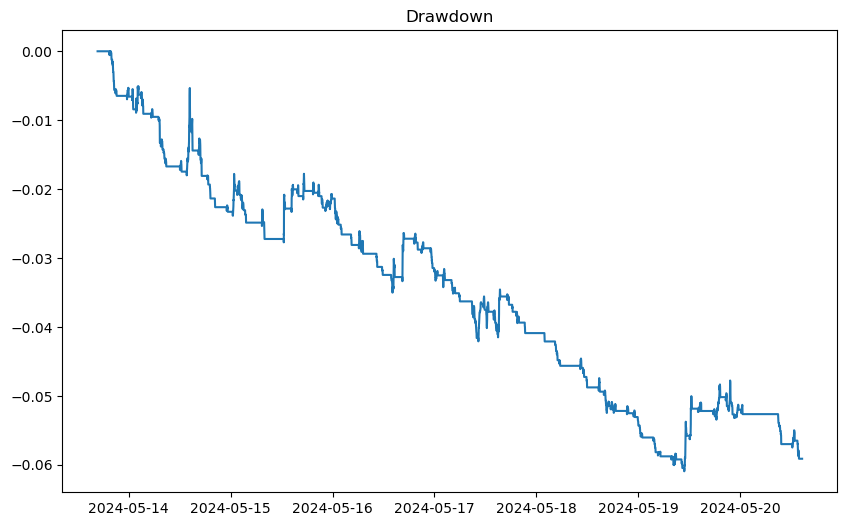

In [24]:
pnl, unr = backtest(df, 0.001)
calculate_metrics(pnl, unr, df)